In [1]:
import numpy,sys,matplotlib,pandas,pickle
import scanpy

scanpy.settings.verbosity = 4
scanpy.settings.n_jobs=8
scanpy.logging.print_versions()

%matplotlib inline

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


# 1. Read data

In [2]:
adata = scanpy.read_10x_mtx('/Volumes/omics4tb2/alomana/projects/i18/results/10x/aggregated/outs/filtered_feature_bc_matrix',var_names='gene_symbols',cache=True)
adata.var_names_make_unique() 

... reading from cache file cache/Volumes-omics4tb2-alomana-projects-i18-results-10x-aggregated-outs-filtered_feature_bc_matrix-matrix.h5ad


# 2. Quality control

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


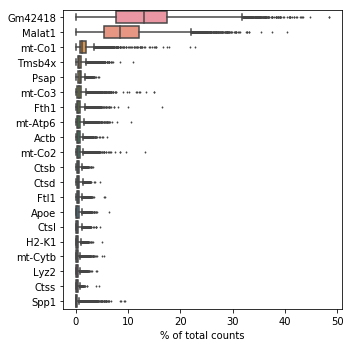

In [3]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

In [4]:
scanpy.pp.filter_cells(adata, min_genes=200)
scanpy.pp.filter_genes(adata, min_cells=3)

filtered out 344 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 16854 genes that are detectedin less than 3 cells


['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6', 'mt-Co3', 'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb'] 13


... storing 'feature_types' as categorical


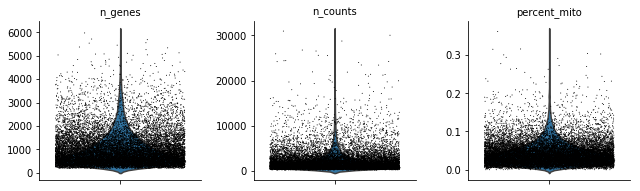

In [5]:
mito_genes=[element for element in adata.var_names if element[:2] == 'mt']
print(mito_genes,len(mito_genes))

adata.obs['percent_mito']=numpy.sum(adata[:,mito_genes].X,axis=1).A1/numpy.sum(adata.X,axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
scanpy.pl.violin(adata,['n_genes','n_counts','percent_mito'],jitter=0.4,multi_panel=True)

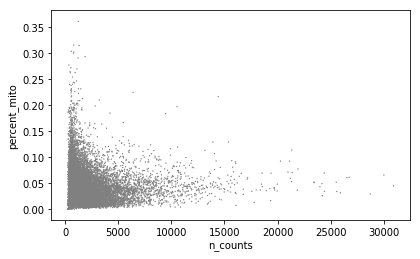

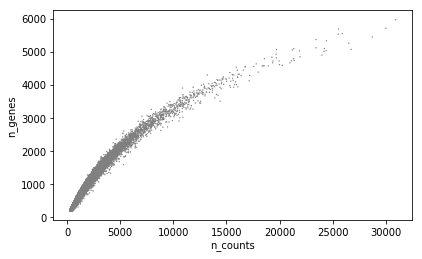

In [6]:
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [7]:
adata

AnnData object with n_obs × n_vars = 16541 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [8]:
print('remove high mito')
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)
print()

remove high mito
View of AnnData object with n_obs × n_vars = 11485 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



8.520520448684692 12.738192319869995
counts lower and upper bounds 367.2249951128508 6832.473859902639
remove low n_count
View of AnnData object with n_obs × n_vars = 11386 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove high n_count
View of AnnData object with n_obs × n_vars = 10940 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



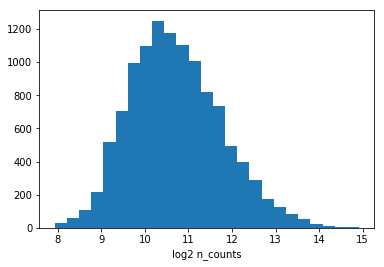

In [9]:
log2counts=numpy.log2(adata.obs['n_counts'])
log2counts.hist(grid=False,bins=25)
matplotlib.pyplot.xlabel('log2 n_counts')

log2LB=log2counts.median()-(2*log2counts.std())
log2UB=log2counts.median()+(2*log2counts.std())
print(log2LB,log2UB)

LB=2**log2LB
UB=2**log2UB
totalUMI=UB

print('counts lower and upper bounds',LB,UB)

print('remove low n_count')
adata = adata[adata.obs['n_counts'] > LB, :]
print(adata)
print()

print('remove high n_count')
adata = adata[adata.obs['n_counts'] < UB, :]
print(adata)
print()

8.160757314140024 11.305273329231902
counts lower and upper bounds 286.1756901763972 2530.6167674606
remove low n_genes
View of AnnData object with n_obs × n_vars = 10769 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

remove high n_genes
View of AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'



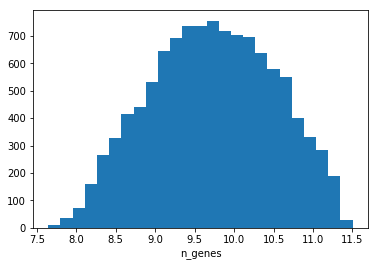

In [10]:
log2genes=numpy.log2(adata.obs['n_genes'])
log2genes.hist(grid=False,bins=25)
matplotlib.pyplot.xlabel('n_genes')

log2LB=log2genes.median()-(2*log2genes.std())
log2UB=log2genes.median()+(2*log2genes.std())
print(log2LB,log2UB)

LB=2**log2LB
UB=2**log2UB

print('counts lower and upper bounds',LB,UB)

print('remove low n_genes')
adata = adata[adata.obs['n_genes'] > LB, :]
print(adata)
print()

print('remove high n_genes')
adata = adata[adata.obs['n_genes'] < UB, :]
print(adata)
print()

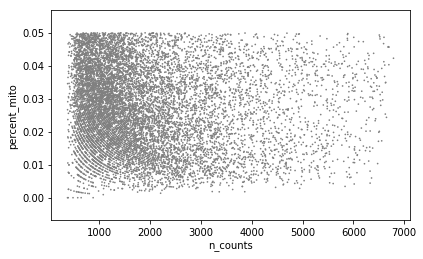

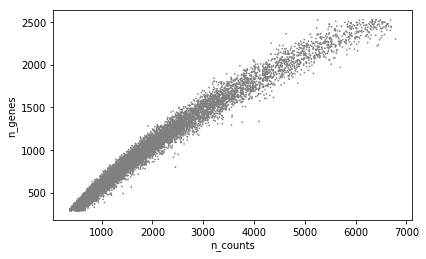

In [11]:
scanpy.pl.scatter(adata, x='n_counts', y='percent_mito')
scanpy.pl.scatter(adata, x='n_counts', y='n_genes')

In [12]:
adata

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [13]:
print(totalUMI)
scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=totalUMI)

6832.473859902639
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
scanpy.pp.log1p(adata)

In [15]:
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


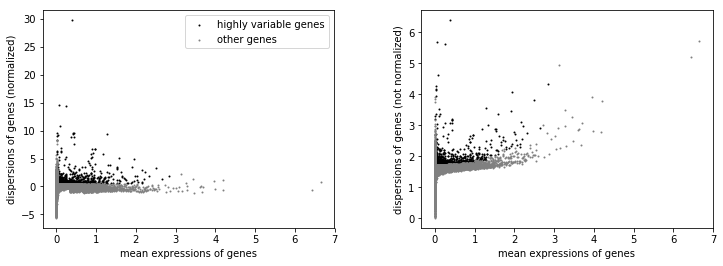

In [16]:
scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3, min_disp=0.5)
scanpy.pl.highly_variable_genes(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [18]:
sum(adata.var['highly_variable'])

1425

In [19]:
print(adata)
adata = adata[:,adata.var['highly_variable']]
print(adata)

AnnData object with n_obs × n_vars = 10712 × 14199 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
View of AnnData object with n_obs × n_vars = 10712 × 1425 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [20]:
# placeholder to regress cell cyle!!!!!!!!

In [21]:
# simple regression of unwanted soruces of variation
scanpy.pp.regress_out(adata,['n_counts','percent_mito'],n_jobs=1) #! strangely, if the n_jobs is not defined to one, it fails to complete the task

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:12)


In [22]:
scanpy.pp.scale(adata,max_value=10)

    ... clipping at max_value 10


# 3. Annotation

In [23]:
cellIDs=adata.obs_names.tolist()

day_labels=[]
for cellID in cellIDs:
    if '-1' in cellID:
        day_labels.append('control_0h')
    elif '-2' in cellID:
        day_labels.append('infected_4h')
    elif '-3' in cellID:
        day_labels.append('infected_24ha')
    elif '-4' in cellID:
        day_labels.append('infected_24hb')
    else:
        print('error!')
        
adata.obs['day_label']=day_labels
print(len(cellIDs),len(day_labels))

a=day_labels.count('control_0h')
b=day_labels.count('infected_4h')
c=day_labels.count('infected_24ha')
d=day_labels.count('infected_24hb')

print(a,b,c,d)

10712 10712
5255 1372 2094 1991


In [24]:
# store cell IDs for further analysis
jarFile='/Volumes/omics4tb2/alomana/projects/i18/results/10x/selectedIDs/selected_ids.pickle'
f=open(jarFile,'wb')
pickle.dump(cellIDs,f)
f.close()

# 4. Visualization

In [25]:
scanpy.tl.pca(adata,svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


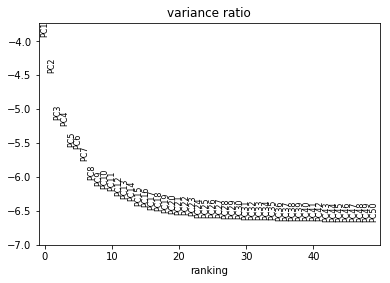

In [26]:
scanpy.pl.pca_variance_ratio(adata,log=True,n_pcs=50)

... storing 'day_label' as categorical


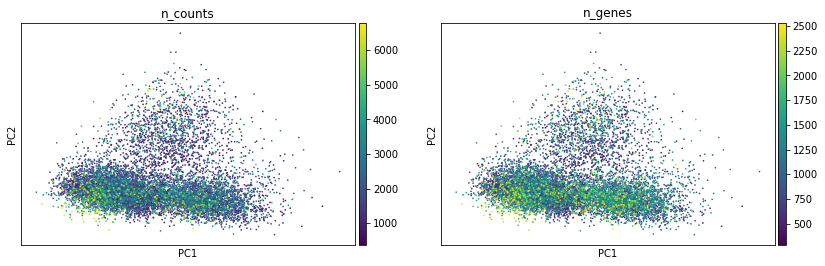

In [27]:
scanpy.pl.pca(adata,color=['n_counts','n_genes'],palette='viridis')

In [28]:
scanpy.tl.tsne(adata,n_pcs=40,n_jobs=8)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10712 samples in 0.020s...
[t-SNE] Computed neighbors for 10712 samples in 5.932s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10712
[t-SNE] Computed conditional probabilities for sample 2000 / 10712
[t-SNE] Computed conditional probabilities for sample 3000 / 10712
[t-SNE] Computed conditional probabilities for sample 4000 / 10712
[t-SNE] Computed conditional probabilities for sample 5000 / 10712
[t-SNE] Computed conditional probabilities for sample 6000 / 10712
[t-SNE] Computed conditional probabilities for sample 7000 / 10712
[t-SNE] Computed conditional probabilities for sample 8000 / 10712
[t-SNE] Computed conditional probabilities for sample 9000 / 10712
[t-SNE] Computed conditional probabilities for sample 10000 / 10712
[t-SNE] Computed conditional probabilities for sample 10712 / 10712
[t-SNE] Mea

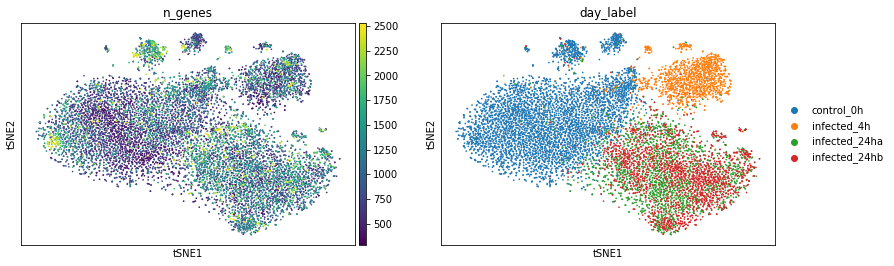

In [29]:
scanpy.pl.tsne(adata,color=['n_genes','day_label'])

In [30]:
scanpy.pp.neighbors(adata,n_neighbors=15,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.tl.leiden(adata)

computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/anaconda3/lib/python3.7/site-pack

    computed neighbors (0:00:04)
    computed connectivities (0:00:01)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


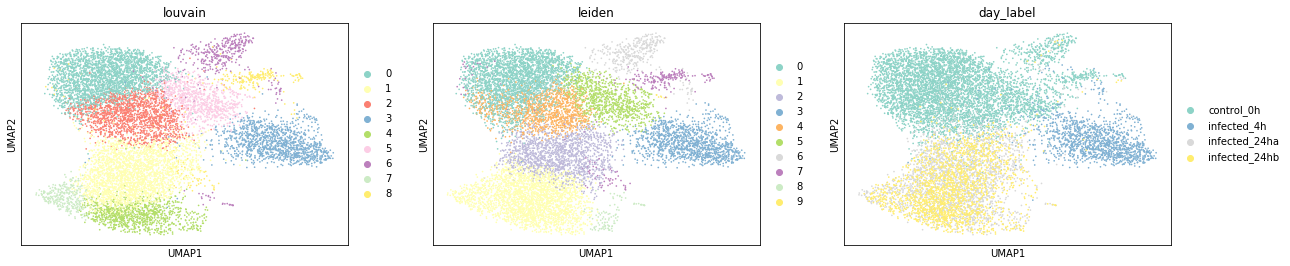

In [31]:
scanpy.pl.umap(adata, color=['louvain','leiden','day_label'],palette='Set3')

ranking genes
    consider 'leiden' groups:
    with sizes: [2675 2491 1482 1222 1167  930  363  275  100    7]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


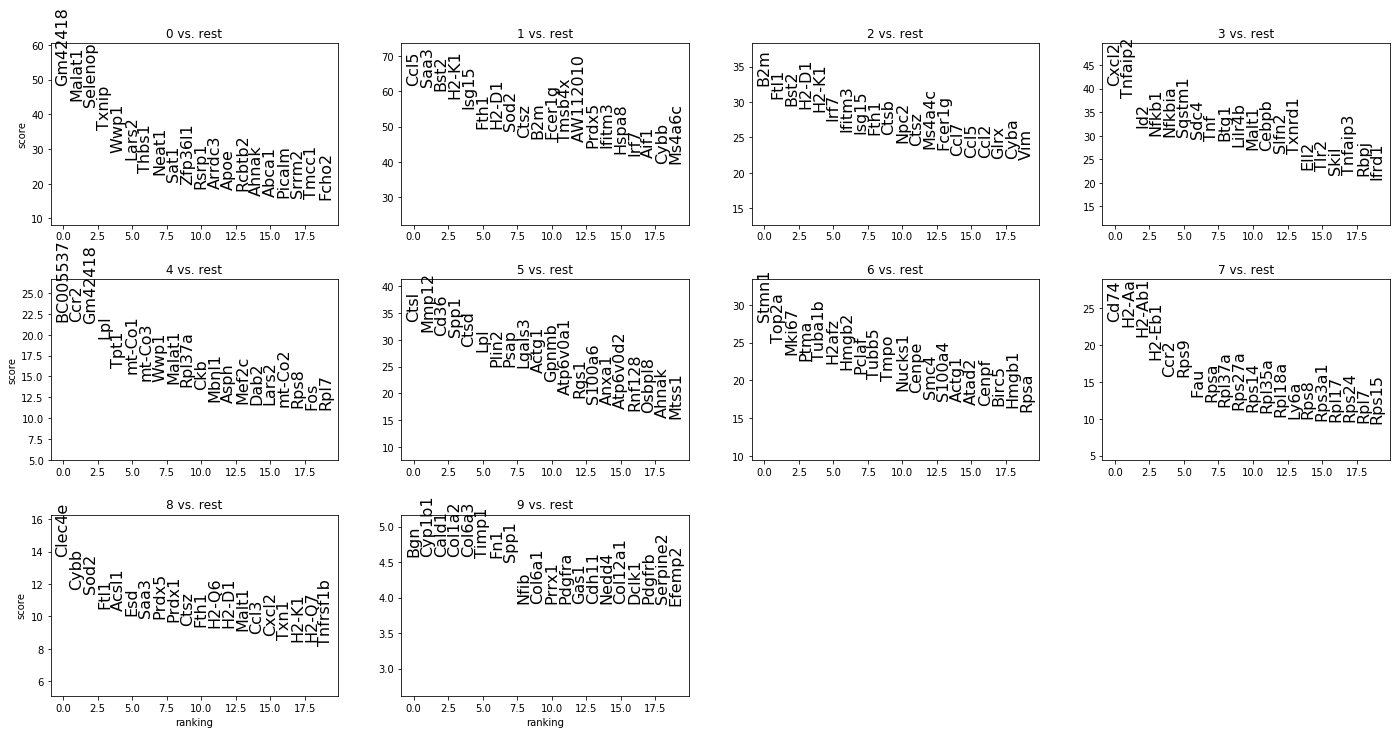

In [32]:
scanpy.tl.rank_genes_groups(adata,'leiden',method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=20, sharey=False,fontsize=16)

ranking genes
    consider 'day_label' groups:
    with sizes: [5255 1372 2094 1991]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


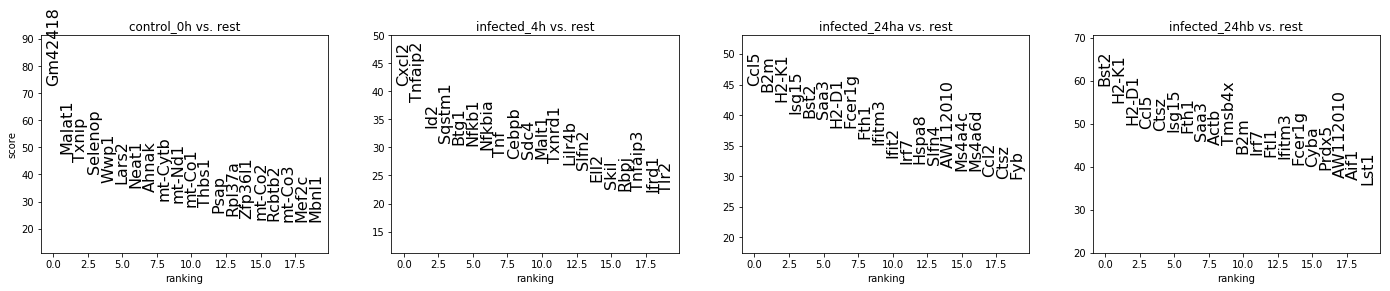

In [33]:
scanpy.tl.rank_genes_groups(adata,'day_label',method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, n_genes=20, sharey=False,fontsize=16)

In [34]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(25)

,control_0h_n,control_0h_p,control_0h_l,infected_4h_n,infected_4h_p,infected_4h_l,infected_24ha_n,infected_24ha_p,infected_24ha_l,infected_24hb_n,infected_24hb_p,infected_24hb_l
0,Gm42418,0.000000e+00,1.944616,Cxcl2,0.000000e+00,5.573637,Ccl5,0.000000e+00,3.720856,Bst2,0.000000e+00,3.115130
1,Malat1,0.000000e+00,0.830768,Tnfaip2,0.000000e+00,3.106157,B2m,0.000000e+00,1.577144,H2-K1,0.000000e+00,2.006879
2,Txnip,0.000000e+00,2.315138,Id2,5.416294e-243,2.952180,H2-K1,0.000000e+00,1.555290,H2-D1,0.000000e+00,1.759079
3,Selenop,0.000000e+00,1.986345,Sqstm1,1.017481e-206,2.471712,Isg15,0.000000e+00,2.650710,Ccl5,0.000000e+00,4.185374
4,Wwp1,1.233968e-295,1.983760,Btg1,1.742528e-201,2.121615,Bst2,0.000000e+00,2.188042,Ctsz,0.000000e+00,2.359333
5,Lars2,6.009809e-291,1.239164,Nfkb1,8.041106e-198,2.507479,Saa3,0.000000e+00,3.624468,Isg15,0.000000e+00,3.233159
6,Neat1,7.173616e-270,1.114661,Nfkbia,6.388982e-189,2.432989,H2-D1,0.000000e+00,1.358794,Fth1,0.000000e+00,1.774199
7,Ahnak,2.464066e-246,1.421113,Tnf,5.416398e-175,3.372183,Fcer1g,0.000000e+00,1.939828,Saa3,0.000000e+00,4.496478
8,mt-Cytb,1.091114e-202,1.015610,Cebpb,1.593423e-170,1.904894,Fth1,2.601079e-283,1.314534,Actb,0.000000e+00,1.283473
9,mt-Nd1,9.164490e-193,1.028672,Sdc4,6.881199e-170,2.466312,Ifitm3,2.819590e-268,1.895387,Tmsb4x,0.000000e+00,1.251230


ranking genes
    consider 'louvain' groups:
    with sizes: [2575 1250]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


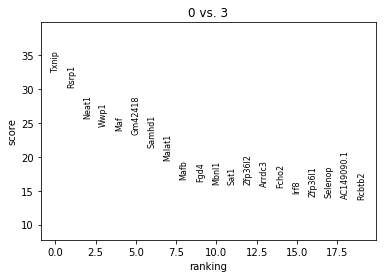

In [35]:
scanpy.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='3', method='wilcoxon')
scanpy.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/Users/alomana/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


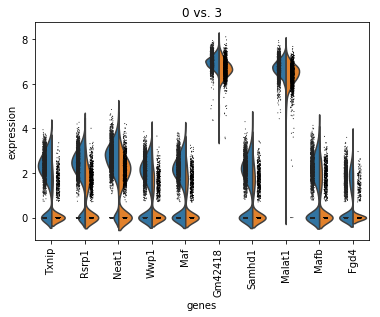

In [36]:
scanpy.pl.rank_genes_groups_violin(adata, groups='0', n_genes=10)